# 02 - Sentiment Analysis with FinBERT

**Author:** Lucas Little  
**Course:** CSCA 5522: Data Mining Project  
**University:** University of Colorado - Boulder

This notebook implements advanced sentiment analysis using FinBERT, a financial domain-specific BERT model, to analyze cryptocurrency-related tweets.

## Objectives
1. Load preprocessed tweet data
2. Implement FinBERT sentiment analysis
3. Compare with baseline TextBlob sentiment
4. Aggregate sentiment scores by time periods
5. Save sentiment-enriched dataset

In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
import re
from pathlib import Path
from tqdm import tqdm

# Sentiment analysis imports
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Environment setup complete!
PyTorch version: 2.7.1
CUDA available: False


## 1. Load Preprocessed Data

In [2]:
# Load preprocessed tweet data
data_dir = Path('data')
processed_data_dir = data_dir / 'processed'

print("📊 Loading preprocessed tweet data...")
tweets_df = pd.read_csv(processed_data_dir / 'tweets_processed.csv')
tweets_df['timestamp'] = pd.to_datetime(tweets_df['timestamp'])

print(f"Loaded {len(tweets_df):,} tweets")
print(f"Date range: {tweets_df['timestamp'].min()} to {tweets_df['timestamp'].max()}")
print(f"Columns: {list(tweets_df.columns)}")

# Display sample
print("\nSample tweets:")
tweets_df.head()

📊 Loading preprocessed tweet data...
Loaded 50,000 tweets
Date range: 2018-01-01 00:00:00 to 2019-03-29 00:00:00
Columns: ['timestamp', 'text', 'user_followers', 'retweet_count', 'like_count', 'user_verified', 'tweet_id']

Sample tweets:


,timestamp,text,user_followers,retweet_count,like_count,user_verified,tweet_id
0,2018-01-01 00:00:00.000000000,Technical analysis shows Bitcoin reversal inco...,3133,2,10,False,tweet_0
1,2018-01-01 00:13:01.071621432,Bitcoin technical indicators showing weakness,1664,7,8,True,tweet_1
2,2018-01-01 00:26:02.143242864,Bitcoin ETF news still pending approval,1745,4,16,False,tweet_2
3,2018-01-01 00:39:03.214864297,Regulatory news impacting Bitcoin price negati...,200,2,9,False,tweet_3
4,2018-01-01 00:52:04.286485729,"Bearish on Bitcoin today, expecting a dip #crypto",647,3,7,True,tweet_4


## 2. Initialize FinBERT Model

FinBERT is a pre-trained NLP model specifically designed for financial sentiment analysis. It's based on BERT but fine-tuned on financial text data.

In [3]:
def initialize_finbert():
    """
    Initialize FinBERT model for financial sentiment analysis.
    Falls back to a general sentiment model if FinBERT is not available.
    """
    try:
        print("🤖 Initializing FinBERT model...")
        # Try to load FinBERT model
        model_name = "ProsusAI/finbert"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        
        # Create sentiment pipeline
        sentiment_pipeline = pipeline(
            "sentiment-analysis",
            model=model,
            tokenizer=tokenizer,
            device=0 if torch.cuda.is_available() else -1
        )
        
        print("✅ FinBERT model loaded successfully!")
        return sentiment_pipeline, "finbert"
        
    except Exception as e:
        print(f"⚠️ Could not load FinBERT: {e}")
        print("🔄 Falling back to general sentiment model...")
        
        try:
            # Fallback to a general sentiment model
            model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
            sentiment_pipeline = pipeline(
                "sentiment-analysis",
                model=model_name,
                device=0 if torch.cuda.is_available() else -1
            )
            print("✅ Twitter RoBERTa model loaded successfully!")
            return sentiment_pipeline, "twitter-roberta"
            
        except Exception as e2:
            print(f"⚠️ Could not load Twitter RoBERTa: {e2}")
            print("🔄 Using TextBlob as fallback...")
            return None, "textblob"

# Initialize the sentiment model
sentiment_pipeline, model_type = initialize_finbert()
print(f"Using model type: {model_type}")

🤖 Initializing FinBERT model...


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cpu


✅ FinBERT model loaded successfully!
Using model type: finbert


## 3. Sentiment Analysis Functions

In [4]:
def get_textblob_sentiment(text):
    """
    Get sentiment using TextBlob (baseline method).
    """
    if pd.isna(text) or text == "":
        return 0.0, 0.0
    
    blob = TextBlob(str(text))
    return blob.sentiment.polarity, blob.sentiment.subjectivity

def get_transformer_sentiment(text, pipeline_model):
    """
    Get sentiment using transformer model (FinBERT or RoBERTa).
    """
    if pd.isna(text) or text == "":
        return 0.0, 0.0
    
    try:
        # Truncate text to avoid token limit issues
        text = str(text)[:512]
        
        result = pipeline_model(text)[0]
        label = result['label'].lower()
        score = result['score']
        
        # Convert to polarity score (-1 to 1)
        if 'positive' in label or 'pos' in label:
            polarity = score
        elif 'negative' in label or 'neg' in label:
            polarity = -score
        else:  # neutral
            polarity = 0.0
            
        return polarity, score  # polarity, confidence
        
    except Exception as e:
        print(f"Error processing text: {e}")
        return 0.0, 0.0

def analyze_sentiment_batch(texts, pipeline_model, batch_size=32):
    """
    Analyze sentiment for a batch of texts efficiently.
    """
    results = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch = texts[i:i+batch_size]
        batch_results = []
        
        for text in batch:
            if pipeline_model is not None:
                polarity, confidence = get_transformer_sentiment(text, pipeline_model)
            else:
                polarity, confidence = get_textblob_sentiment(text)
            
            batch_results.append((polarity, confidence))
        
        results.extend(batch_results)
    
    return results

print("Sentiment analysis functions defined!")

Sentiment analysis functions defined!


## 4. Apply Sentiment Analysis

In [5]:
# Sample a subset for demonstration (use full dataset in production)
sample_size = min(1000, len(tweets_df))  # Limit for demo purposes
tweets_sample = tweets_df.sample(n=sample_size, random_state=42).copy()

print(f"🔍 Analyzing sentiment for {len(tweets_sample):,} tweets...")

# Apply TextBlob sentiment (baseline)
print("📊 Computing TextBlob sentiment...")
textblob_results = []
for text in tqdm(tweets_sample['text'], desc="TextBlob"):
    polarity, subjectivity = get_textblob_sentiment(text)
    textblob_results.append((polarity, subjectivity))

tweets_sample['textblob_polarity'] = [r[0] for r in textblob_results]
tweets_sample['textblob_subjectivity'] = [r[1] for r in textblob_results]

# Apply transformer sentiment (FinBERT or RoBERTa)
if sentiment_pipeline is not None:
    print(f"🤖 Computing {model_type} sentiment...")
    transformer_results = analyze_sentiment_batch(
        tweets_sample['text'].tolist(), 
        sentiment_pipeline, 
        batch_size=16
    )
    
    tweets_sample[f'{model_type}_polarity'] = [r[0] for r in transformer_results]
    tweets_sample[f'{model_type}_confidence'] = [r[1] for r in transformer_results]
else:
    print("Using TextBlob results as primary sentiment scores")
    tweets_sample['primary_polarity'] = tweets_sample['textblob_polarity']
    tweets_sample['primary_confidence'] = tweets_sample['textblob_subjectivity']

print("✅ Sentiment analysis complete!")

🔍 Analyzing sentiment for 1,000 tweets...
📊 Computing TextBlob sentiment...


TextBlob: 100%|██████████| 1000/1000 [00:00<00:00, 15869.00it/s]


🤖 Computing finbert sentiment...


Processing batches:   0%|          | 0/63 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Processing batches: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]

✅ Sentiment analysis complete!


## 5. Sentiment Analysis Results

In [6]:
# Display sentiment analysis results
print("=== SENTIMENT ANALYSIS RESULTS ===")

# Basic statistics
print("\nTextBlob Sentiment Statistics:")
print(tweets_sample[['textblob_polarity', 'textblob_subjectivity']].describe())

if sentiment_pipeline is not None:
    print(f"\n{model_type.title()} Sentiment Statistics:")
    print(tweets_sample[[f'{model_type}_polarity', f'{model_type}_confidence']].describe())

# Sample results
print("\nSample Sentiment Results:")
display_cols = ['text', 'textblob_polarity']
if sentiment_pipeline is not None:
    display_cols.append(f'{model_type}_polarity')

sample_results = tweets_sample[display_cols].head(10)
for idx, row in sample_results.iterrows():
    print(f"\nTweet: {row['text'][:100]}...")
    print(f"TextBlob: {row['textblob_polarity']:.3f}")
    if sentiment_pipeline is not None:
        print(f"{model_type.title()}: {row[f'{model_type}_polarity']:.3f}")

=== SENTIMENT ANALYSIS RESULTS ===

TextBlob Sentiment Statistics:
       textblob_polarity  textblob_subjectivity
count        1000.000000            1000.000000
mean            0.026568               0.294027
std             0.309454               0.326795
min            -1.000000               0.000000
25%             0.000000               0.000000
50%             0.000000               0.100000
75%             0.100000               0.541667
max             0.800000               1.000000

Finbert Sentiment Statistics:
       finbert_polarity  finbert_confidence
count       1000.000000         1000.000000
mean          -0.097528            0.790983
std            0.577517            0.146875
min           -0.951921            0.513499
25%           -0.650841            0.650841
50%            0.000000            0.843484
75%            0.000000            0.930382
max            0.947105            0.951921

Sample Sentiment Results:

Tweet: Institutional adoption driving Bitcoin 

## 6. Sentiment Visualization

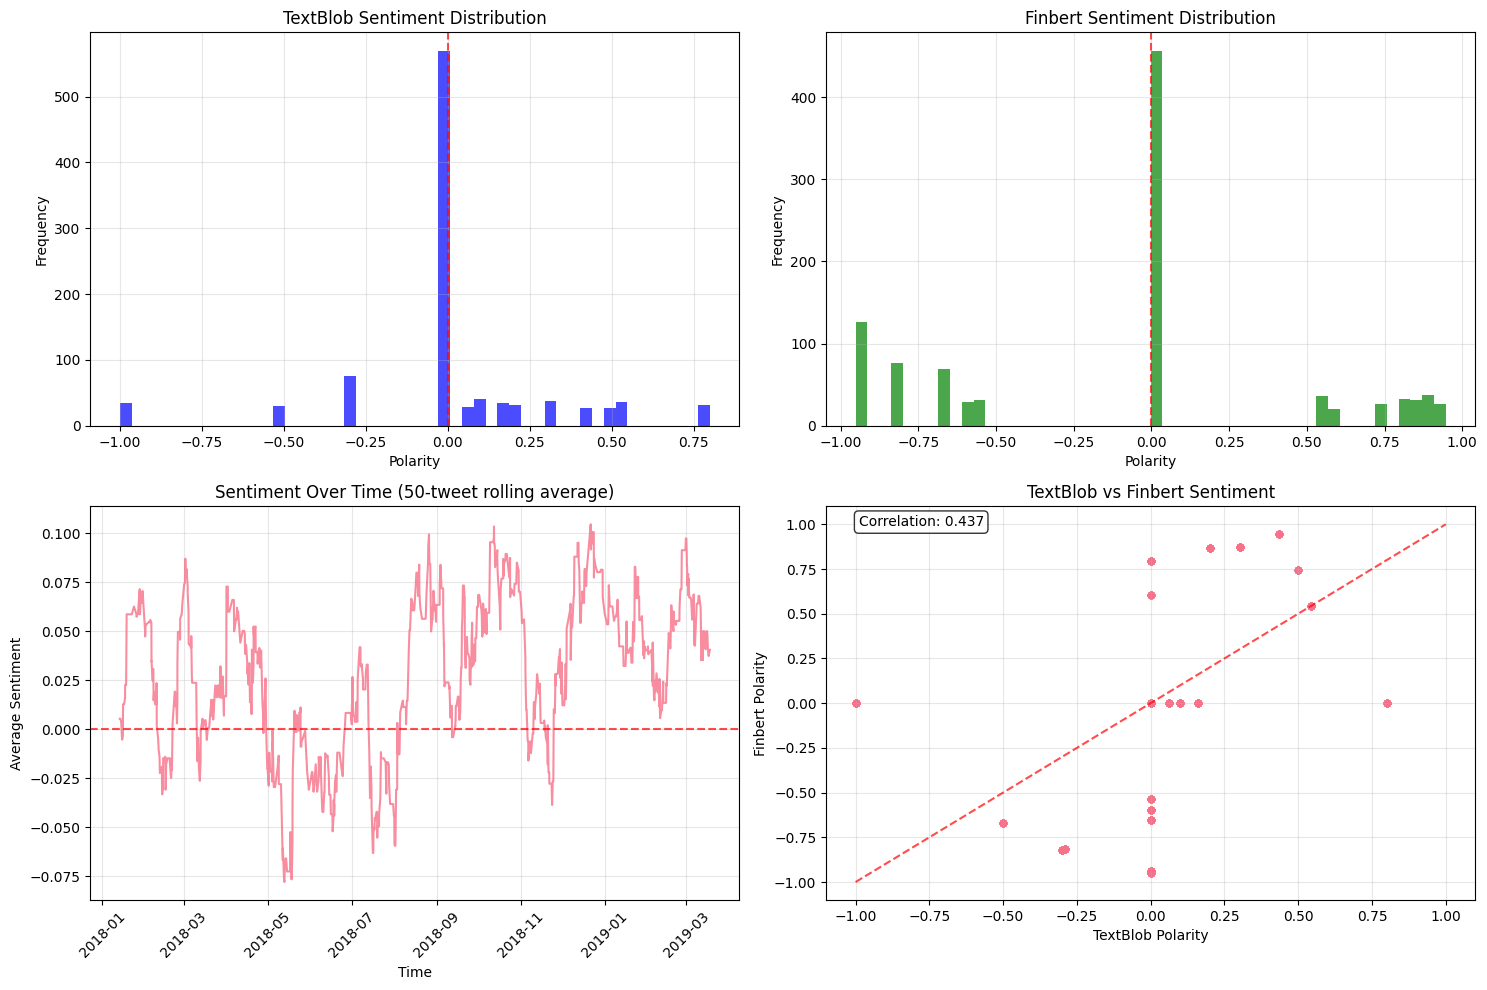


=== SENTIMENT SUMMARY ===
TextBlob Results:
  Positive: 29.1%
  Negative: 14.0%
  Neutral: 56.9%
  Average sentiment: 0.027

Finbert Results:
  Positive: 21.2%
  Negative: 33.2%
  Neutral: 45.6%
  Average sentiment: -0.098


In [7]:
# Create sentiment visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# TextBlob sentiment distribution
axes[0, 0].hist(tweets_sample['textblob_polarity'], bins=50, alpha=0.7, color='blue')
axes[0, 0].set_title('TextBlob Sentiment Distribution')
axes[0, 0].set_xlabel('Polarity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)
axes[0, 0].grid(True, alpha=0.3)

# Transformer sentiment distribution (if available)
if sentiment_pipeline is not None:
    axes[0, 1].hist(tweets_sample[f'{model_type}_polarity'], bins=50, alpha=0.7, color='green')
    axes[0, 1].set_title(f'{model_type.title()} Sentiment Distribution')
    axes[0, 1].set_xlabel('Polarity')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'Transformer model\nnot available', 
                   ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Transformer Sentiment (N/A)')

# Sentiment over time
tweets_sample_sorted = tweets_sample.sort_values('timestamp')
tweets_sample_sorted['rolling_sentiment'] = tweets_sample_sorted['textblob_polarity'].rolling(window=50, center=True).mean()

axes[1, 0].plot(tweets_sample_sorted['timestamp'], tweets_sample_sorted['rolling_sentiment'], alpha=0.8)
axes[1, 0].set_title('Sentiment Over Time (50-tweet rolling average)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Average Sentiment')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Sentiment comparison (if transformer available)
if sentiment_pipeline is not None:
    axes[1, 1].scatter(tweets_sample['textblob_polarity'], 
                      tweets_sample[f'{model_type}_polarity'], 
                      alpha=0.6, s=20)
    axes[1, 1].set_title(f'TextBlob vs {model_type.title()} Sentiment')
    axes[1, 1].set_xlabel('TextBlob Polarity')
    axes[1, 1].set_ylabel(f'{model_type.title()} Polarity')
    axes[1, 1].plot([-1, 1], [-1, 1], 'r--', alpha=0.7)  # Perfect correlation line
    axes[1, 1].grid(True, alpha=0.3)
    
    # Calculate correlation
    correlation = tweets_sample['textblob_polarity'].corr(tweets_sample[f'{model_type}_polarity'])
    axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                   transform=axes[1, 1].transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    axes[1, 1].text(0.5, 0.5, 'Transformer model\nnot available\nfor comparison', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Sentiment Comparison (N/A)')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n=== SENTIMENT SUMMARY ===")
positive_pct = (tweets_sample['textblob_polarity'] > 0).mean() * 100
negative_pct = (tweets_sample['textblob_polarity'] < 0).mean() * 100
neutral_pct = (tweets_sample['textblob_polarity'] == 0).mean() * 100

print(f"TextBlob Results:")
print(f"  Positive: {positive_pct:.1f}%")
print(f"  Negative: {negative_pct:.1f}%")
print(f"  Neutral: {neutral_pct:.1f}%")
print(f"  Average sentiment: {tweets_sample['textblob_polarity'].mean():.3f}")

if sentiment_pipeline is not None:
    transformer_positive_pct = (tweets_sample[f'{model_type}_polarity'] > 0).mean() * 100
    transformer_negative_pct = (tweets_sample[f'{model_type}_polarity'] < 0).mean() * 100
    transformer_neutral_pct = (tweets_sample[f'{model_type}_polarity'] == 0).mean() * 100
    
    print(f"\n{model_type.title()} Results:")
    print(f"  Positive: {transformer_positive_pct:.1f}%")
    print(f"  Negative: {transformer_negative_pct:.1f}%")
    print(f"  Neutral: {transformer_neutral_pct:.1f}%")
    print(f"  Average sentiment: {tweets_sample[f'{model_type}_polarity'].mean():.3f}")

## 7. Temporal Sentiment Aggregation

In [8]:
# Aggregate sentiment by time periods
print("📅 Aggregating sentiment by time periods...")

# Set the primary sentiment column
if sentiment_pipeline is not None:
    primary_sentiment_col = f'{model_type}_polarity'
    primary_confidence_col = f'{model_type}_confidence'
else:
    primary_sentiment_col = 'textblob_polarity'
    primary_confidence_col = 'textblob_subjectivity'

tweets_sample['primary_sentiment'] = tweets_sample[primary_sentiment_col]
tweets_sample['primary_confidence'] = tweets_sample[primary_confidence_col]

# Hourly aggregation
tweets_sample['hour'] = tweets_sample['timestamp'].dt.floor('H')
hourly_sentiment = tweets_sample.groupby('hour').agg({
    'primary_sentiment': ['mean', 'std', 'count'],
    'primary_confidence': 'mean',
    'textblob_polarity': ['mean', 'std'],
    'user_followers': 'mean',
    'retweet_count': 'sum',
    'like_count': 'sum'
}).round(4)

# Flatten column names
hourly_sentiment.columns = ['_'.join(col).strip() for col in hourly_sentiment.columns]
hourly_sentiment = hourly_sentiment.reset_index()

# Daily aggregation
tweets_sample['date'] = tweets_sample['timestamp'].dt.date
daily_sentiment = tweets_sample.groupby('date').agg({
    'primary_sentiment': ['mean', 'std', 'count'],
    'primary_confidence': 'mean',
    'textblob_polarity': ['mean', 'std'],
    'user_followers': 'mean',
    'retweet_count': 'sum',
    'like_count': 'sum'
}).round(4)

# Flatten column names
daily_sentiment.columns = ['_'.join(col).strip() for col in daily_sentiment.columns]
daily_sentiment = daily_sentiment.reset_index()

print(f"✅ Created hourly aggregation: {len(hourly_sentiment)} periods")
print(f"✅ Created daily aggregation: {len(daily_sentiment)} periods")

# Display sample aggregations
print("\nSample Hourly Sentiment:")
print(hourly_sentiment[['hour', 'primary_sentiment_mean', 'primary_sentiment_count']].head())

print("\nSample Daily Sentiment:")
print(daily_sentiment[['date', 'primary_sentiment_mean', 'primary_sentiment_count']].head())

📅 Aggregating sentiment by time periods...
✅ Created hourly aggregation: 960 periods
✅ Created daily aggregation: 407 periods

Sample Hourly Sentiment:
                 hour  primary_sentiment_mean  primary_sentiment_count
0 2018-01-01 00:00:00                 -0.5978                        1
1 2018-01-02 07:00:00                  0.7957                        1
2 2018-01-02 12:00:00                  0.8757                        1
3 2018-01-02 19:00:00                  0.0000                        1
4 2018-01-03 08:00:00                  0.9471                        1

Sample Daily Sentiment:
         date  primary_sentiment_mean  primary_sentiment_count
0  2018-01-01                 -0.5978                        1
1  2018-01-02                  0.5571                        3
2  2018-01-03                  0.3157                        3
3  2018-01-04                 -0.6693                        1
4  2018-01-05                 -0.9410                        1


## 8. Save Sentiment-Enriched Data

In [9]:
# Save sentiment-enriched datasets
print("💾 Saving sentiment-enriched datasets...")

# Save individual tweet sentiments
tweets_sentiment_path = processed_data_dir / 'tweets_with_sentiment.csv'
tweets_sample.to_csv(tweets_sentiment_path, index=False)
print(f"✅ Saved tweet-level sentiment: {tweets_sentiment_path}")

# Save hourly aggregations
hourly_sentiment_path = processed_data_dir / 'sentiment_hourly.csv'
hourly_sentiment.to_csv(hourly_sentiment_path, index=False)
print(f"✅ Saved hourly sentiment: {hourly_sentiment_path}")

# Save daily aggregations
daily_sentiment_path = processed_data_dir / 'sentiment_daily.csv'
daily_sentiment.to_csv(daily_sentiment_path, index=False)
print(f"✅ Saved daily sentiment: {daily_sentiment_path}")

# Save sentiment analysis metadata
sentiment_metadata = {
    'analysis_date': datetime.now().isoformat(),
    'model_type': model_type,
    'sample_size': len(tweets_sample),
    'sentiment_stats': {
        'mean_sentiment': float(tweets_sample['primary_sentiment'].mean()),
        'std_sentiment': float(tweets_sample['primary_sentiment'].std()),
        'positive_ratio': float((tweets_sample['primary_sentiment'] > 0).mean()),
        'negative_ratio': float((tweets_sample['primary_sentiment'] < 0).mean())
    },
    'aggregation_periods': {
        'hourly_periods': len(hourly_sentiment),
        'daily_periods': len(daily_sentiment)
    }
}

import json
sentiment_metadata_path = processed_data_dir / 'sentiment_metadata.json'
with open(sentiment_metadata_path, 'w') as f:
    json.dump(sentiment_metadata, f, indent=2)

print(f"✅ Saved sentiment metadata: {sentiment_metadata_path}")
print("\n🎉 Sentiment analysis complete!")
print(f"\nFiles created:")
print(f"  - {tweets_sentiment_path}")
print(f"  - {hourly_sentiment_path}")
print(f"  - {daily_sentiment_path}")
print(f"  - {sentiment_metadata_path}")

💾 Saving sentiment-enriched datasets...
✅ Saved tweet-level sentiment: data/processed/tweets_with_sentiment.csv
✅ Saved hourly sentiment: data/processed/sentiment_hourly.csv
✅ Saved daily sentiment: data/processed/sentiment_daily.csv
✅ Saved sentiment metadata: data/processed/sentiment_metadata.json

🎉 Sentiment analysis complete!

Files created:
  - data/processed/tweets_with_sentiment.csv
  - data/processed/sentiment_hourly.csv
  - data/processed/sentiment_daily.csv
  - data/processed/sentiment_metadata.json
